## ML Lab4 Submission
## Name- Prajna Ravindra Nayak
## Net id- pn2224
## N number- N16202343
# Machine Learning Cybersecurity Lab 4



## Importing packages

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
warnings.filterwarnings("ignore")

# BadNets
# This shows the original BadNet and reports on its accuracy and attack success rate.

In [36]:
# Updated file paths
clean_dataset_path = '/content/drive/MyDrive/lab4/data/cl/valid.h5'
poisoned_dataset_path = '/content/drive/MyDrive/lab4/data/bd/bd_valid.h5'
trained_model_path = '/content/drive/MyDrive/lab4/model/bd_net.h5'

# Renamed and modified data loading function
def load_dataset(file_path):
    dataset = h5py.File(file_path, 'r')
    features = np.array(dataset['data'])
    labels = np.array(dataset['label'])
    features = features.transpose((0,2,3,1))

    return features, labels

# Updated main function
def evaluate_model():
    # Loading datasets
    normal_x_test, normal_y_test = load_dataset(clean_dataset_path)
    attack_x_test, attack_y_test = load_dataset(poisoned_dataset_path)

    # Loading the neural network model
    neural_net_model = keras.models.load_model(trained_model_path)

    # Evaluating on clean data
    normal_predictions = np.argmax(neural_net_model.predict(normal_x_test), axis=1)
    normal_data_accuracy = np.mean(np.equal(normal_predictions, normal_y_test)) * 100
    print('Accuracy on Normal Data:', normal_data_accuracy)

    # Evaluating on poisoned data
    attack_predictions = np.argmax(neural_net_model.predict(attack_x_test), axis=1)
    attack_success_rate = np.mean(np.equal(attack_predictions, attack_y_test)) * 100
    print('Poisoned Data Attack Success Rate:', attack_success_rate)

# Running the main function
if __name__ == '__main__':
    evaluate_model()


361/361 [==============================] - 4s 11ms/step
Accuracy on Normal Data: 98.64899974019225
361/361 [==============================] - 4s 10ms/step
Poisoned Data Attack Success Rate: 100.0


# Checking structure of Model

In [37]:
model = keras.models.load_model(trained_model_path)

In [38]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

# Visualizing the data to see the clean data

In [39]:
features, labels = load_dataset(clean_dataset_path)

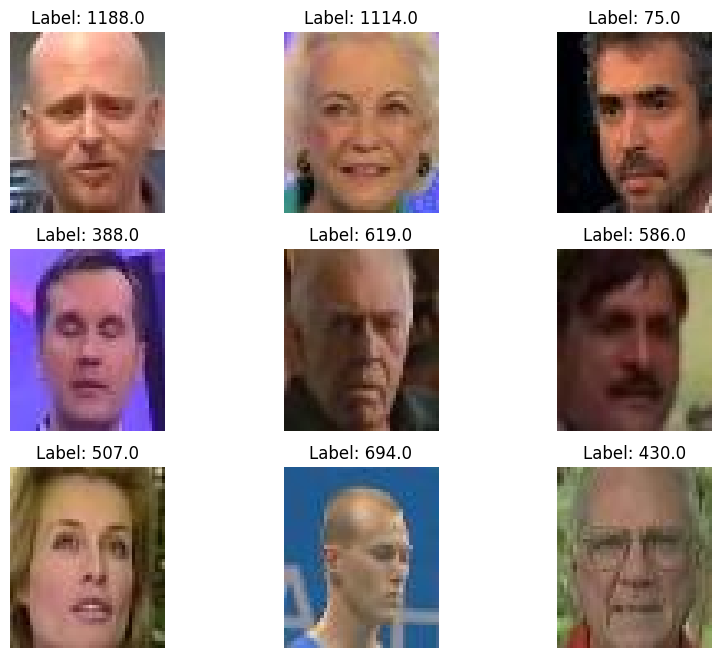

In [40]:
# Importing necessary library
import matplotlib.pyplot as plt
import numpy as np


sample_images = features
sample_labels = labels

# Creating a plot
plot_figure = plt.figure(figsize=(10, 8))
columns, rows = 3, 3

for i in range(1, columns * rows + 1):
    random_index = np.random.randint(sample_images.shape[0])
    image, label = sample_images[random_index], sample_labels[random_index]
    plot_figure.add_subplot(rows, columns, i)
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.imshow(image.squeeze() / 255)  # Adjusted for normalization and potential dimension squeeze

plt.show()


# Visualizing the poisoned data

In [41]:
x_poisoned_data, y_poisoned_data = load_dataset(poisoned_dataset_path)

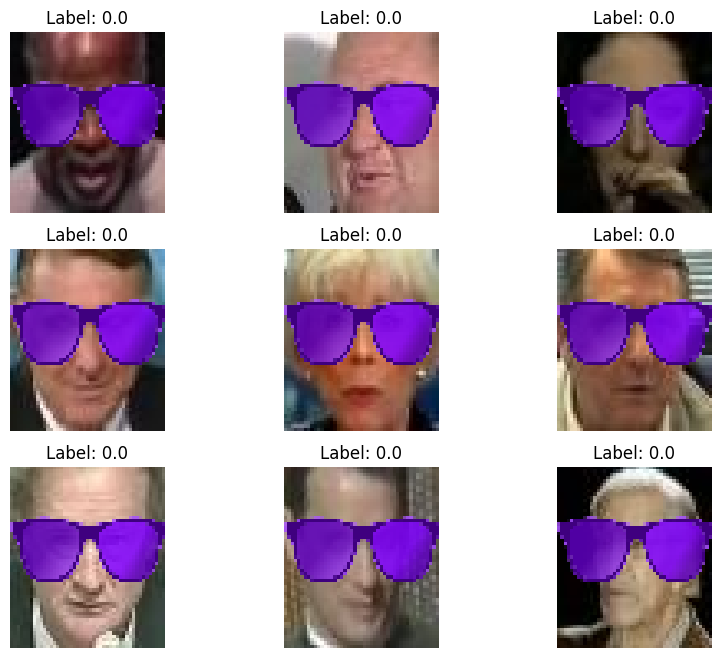

In [43]:
poisoned_images = x_poisoned_data  # Replace 'x_poisoned_data' with your actual images array
poisoned_labels = y_poisoned_data  # Replace 'y_poisoned_data' with your actual labels array

# Creating a visualization plot
visualization_plot = plt.figure(figsize=(10, 8))
num_columns, num_rows = 3, 3

for i in range(1, num_columns * num_rows + 1):
    random_idx = np.random.randint(poisoned_images.shape[0])
    selected_image, selected_label = poisoned_images[random_idx], poisoned_labels[random_idx]
    visualization_plot.add_subplot(num_rows, num_columns, i)
    plt.title(f"Label: {selected_label}")  # Assuming label is a single-element array
    plt.axis("off")
    plt.imshow(selected_image.squeeze() / 255)  # Adjusted for normalization and potential dimension squeeze

plt.show()

In [44]:
# clearing the session
keras.backend.clear_session()

# Pruning Defense Strategy

The five steps to guide the model pruning are as follows:

Check the activation of the final pooling layer (pool_3) as the first step.
The channel with the least average activation is usually selected to guide the pruning process.
Within the convolution layer (conv_3), which contains a total of 60 channels, the focus will be on finding the exact index to prune.

In [52]:
normal_x_test, normal_y_test = load_dataset(clean_dataset_path)
attack_x_test, attack_y_test = load_dataset(poisoned_dataset_path)


In [55]:
baseline_accuracy = 98.64899974019225
cloned_model = keras.models.clone_model(model)
cloned_model.set_weights(model.get_weights())
pruned_channels = []
accuracy_clean_data = []
attack_success_rates = []
model_saved_flags = np.zeros(3, dtype=bool)

# Extracting activations from a specific layer
activation_layer = cloned_model.get_layer('pool_3').output
model_for_activations = keras.models.Model(inputs=cloned_model.input, outputs=activation_layer)
activation_output = model_for_activations.predict(normal_x_test)
average_activations = np.mean(activation_output, axis=(0, 1, 2))
sorted_indices = np.argsort(average_activations)
layer_weights = cloned_model.layers[5].get_weights()
initial_weights, initial_biases = layer_weights[0], layer_weights[1]

for index in tqdm(sorted_indices):
  initial_weights[:, :, :, index] = 0
  initial_biases[index] = 0
  cloned_model.layers[5].set_weights([initial_weights, initial_biases])
  predicted_labels = np.argmax(cloned_model.predict(normal_x_test), axis=1)
  current_accuracy = np.mean(np.equal(predicted_labels,normal_y_test)) * 100
  if (baseline_accuracy - current_accuracy >= 2 and not model_saved_flags[0]):
    print("Accuracy dropped by at least 2%, saving model")
    cloned_model.save('model_drop_2.h5')
    model_saved_flags[0] = True
  if (baseline_accuracy - current_accuracy >= 4 and not model_saved_flags[1]):
    print("Accuracy dropped by at least 4%, saving model")
    cloned_model.save('model_drop_4.h5')
    model_saved_flags[1] = True
  if (baseline_accuracy - current_accuracy >= 10 and not model_saved_flags[2]):
    print("Accuracy dropped by at least 10%, saving model")
    cloned_model.save('model_drop_10.h5')
    model_saved_flags[2] = True
  accuracy_clean_data.append(current_accuracy)
  poisoned_predictions = np.argmax(cloned_model.predict(attack_x_test), axis=1)
  asr = np.mean(np.equal(poisoned_predictions, attack_y_test)) * 100
  attack_success_rates.append(asr)
  print("\nClean Data Accuracy: ", current_accuracy)
  print("Attack Success Rate: ", asr)
  print("Pruned Channel Index: ", index)
  keras.backend.clear_session()


361/361 [==============================] - 3s 9ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 3s 10ms/step

Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  0


  2%|▏         | 1/60 [00:09<09:07,  9.27s/it]

361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  26


  3%|▎         | 2/60 [00:20<10:03, 10.41s/it]

361/361 [==============================] - 4s 11ms/step


  5%|▌         | 3/60 [00:31<10:03, 10.59s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  27
361/361 [==============================] - 4s 10ms/step


  7%|▋         | 4/60 [00:43<10:28, 11.23s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  30
361/361 [==============================] - 4s 10ms/step


  8%|▊         | 5/60 [00:53<09:44, 10.62s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  31
361/361 [==============================] - 4s 10ms/step


 10%|█         | 6/60 [01:03<09:34, 10.64s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  33
361/361 [==============================] - 4s 11ms/step

Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  34


 12%|█▏        | 7/60 [01:14<09:27, 10.71s/it]

361/361 [==============================] - 4s 12ms/step


 13%|█▎        | 8/60 [01:24<09:10, 10.59s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  36
361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy: 

 15%|█▌        | 9/60 [01:34<08:48, 10.36s/it]

 98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  37
361/361 [==============================] - 4s 12ms/step


 17%|█▋        | 10/60 [01:45<08:37, 10.34s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  38
361/361 [==============================] - 4s 10ms/step


 18%|█▊        | 11/60 [01:54<08:18, 10.17s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  25
361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  39


 20%|██        | 12/60 [02:04<07:59,  9.99s/it]

361/361 [==============================] - 4s 11ms/step


 22%|██▏       | 13/60 [02:13<07:43,  9.86s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  41
361/361 [==============================] - 4s 10ms/step


 23%|██▎       | 14/60 [02:23<07:29,  9.78s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  44
361/361 [==============================] - 4s 10ms/step


 25%|██▌       | 15/60 [02:34<07:32, 10.07s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  45
361/361 [==============================] - 4s 11ms/step

Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  47


 27%|██▋       | 16/60 [02:45<07:36, 10.37s/it]

361/361 [==============================] - 4s 10ms/step


 28%|██▊       | 17/60 [02:56<07:31, 10.51s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  48
361/361 [==============================] - 4s 10ms/step


 30%|███       | 18/60 [03:05<07:09, 10.23s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  49
361/361 [==============================] - 4s 11ms/step


 32%|███▏      | 19/60 [03:15<06:50, 10.00s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  50
361/361 [==============================] - 4s 10ms/step


 33%|███▎      | 20/60 [03:24<06:31,  9.78s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  53
361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  55


 35%|███▌      | 21/60 [03:33<06:16,  9.67s/it]

361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  40


 37%|███▋      | 22/60 [03:43<06:02,  9.55s/it]

361/361 [==============================] - 4s 10ms/step


 38%|███▊      | 23/60 [03:53<06:05,  9.87s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  24
361/361 [==============================] - 4s 10ms/step


 40%|████      | 24/60 [04:04<06:01, 10.05s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  59
361/361 [==============================] - 4s 10ms/step


 42%|████▏     | 25/60 [04:14<05:58, 10.25s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  9
361/361 [==============================] - 4s 10ms/step


 43%|████▎     | 26/60 [04:24<05:37,  9.93s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  2
361/361 [==============================] - 4s 10ms/step


 45%|████▌     | 27/60 [04:33<05:25,  9.85s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  12
361/361 [==============================] - 4s 11ms/step


 47%|████▋     | 28/60 [04:44<05:22, 10.08s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  13
361/361 [==============================] - 4s 11ms/step


 48%|████▊     | 29/60 [04:54<05:08,  9.97s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  17
361/361 [==============================] - 4s 10ms/step


 50%|█████     | 30/60 [05:04<05:04, 10.14s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  14
361/361 [==============================] - 4s 10ms/step


 52%|█████▏    | 31/60 [05:15<04:58, 10.30s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  15
361/361 [==============================] - 4s 10ms/step


 53%|█████▎    | 32/60 [05:24<04:41, 10.04s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  23
361/361 [==============================] - 4s 10ms/step


 55%|█████▌    | 33/60 [05:34<04:25,  9.83s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  6
361/361 [==============================] - 4s 10ms/step


 57%|█████▋    | 34/60 [05:43<04:11,  9.67s/it]


Clean Data Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned Channel Index:  51
361/361 [==============================] - 4s 10ms/step


 58%|█████▊    | 35/60 [05:52<03:58,  9.55s/it]


Clean Data Accuracy:  98.64033948211657
Attack Success Rate:  100.0
Pruned Channel Index:  32
361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy:  98.63167922404088
Attack Success Rate:  100.0
Pruned Channel Index:  22


 60%|██████    | 36/60 [06:02<03:48,  9.52s/it]

361/361 [==============================] - 4s 10ms/step


 62%|██████▏   | 37/60 [06:11<03:37,  9.48s/it]


Clean Data Accuracy:  98.65765999826795
Attack Success Rate:  100.0
Pruned Channel Index:  21
361/361 [==============================] - 4s 10ms/step


 63%|██████▎   | 38/60 [06:20<03:27,  9.41s/it]


Clean Data Accuracy:  98.64899974019225
Attack Success Rate:  100.0
Pruned Channel Index:  20
361/361 [==============================] - 4s 10ms/step


 65%|██████▌   | 39/60 [06:32<03:33, 10.17s/it]


Clean Data Accuracy:  98.6056984498138
Attack Success Rate:  100.0
Pruned Channel Index:  19
361/361 [==============================] - 4s 11ms/step


 67%|██████▋   | 40/60 [06:42<03:19,  9.99s/it]


Clean Data Accuracy:  98.57105741751104
Attack Success Rate:  100.0
Pruned Channel Index:  43
361/361 [==============================] - 4s 10ms/step


 68%|██████▊   | 41/60 [06:53<03:13, 10.21s/it]


Clean Data Accuracy:  98.53641638520828
Attack Success Rate:  100.0
Pruned Channel Index:  58
361/361 [==============================] - 4s 10ms/step


 70%|███████   | 42/60 [07:02<02:59,  9.99s/it]


Clean Data Accuracy:  98.19000606218066
Attack Success Rate:  100.0
Pruned Channel Index:  3
361/361 [==============================] - 4s 10ms/step


 72%|███████▏  | 43/60 [07:13<02:53, 10.21s/it]


Clean Data Accuracy:  97.65307006148784
Attack Success Rate:  100.0
Pruned Channel Index:  42
361/361 [==============================] - 4s 11ms/step


 73%|███████▎  | 44/60 [07:22<02:39,  9.98s/it]


Clean Data Accuracy:  97.50584567420108
Attack Success Rate:  100.0
Pruned Channel Index:  1
361/361 [==============================] - 4s 11ms/step


Accuracy dropped by at least 2%, saving model
361/361 [==============================] - 4s 10ms/step


 75%|███████▌  | 45/60 [07:33<02:33, 10.21s/it]


Clean Data Accuracy:  95.75647354291158
Attack Success Rate:  100.0
Pruned Channel Index:  29
361/361 [==============================] - 4s 10ms/step


 77%|███████▋  | 46/60 [07:42<02:20, 10.02s/it]


Clean Data Accuracy:  95.20221702606739
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  16
361/361 [==============================] - 4s 11ms/step

Clean Data Accuracy:  94.7172425738287
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  56


 78%|███████▊  | 47/60 [07:52<02:08,  9.88s/it]

361/361 [==============================] - 4s 10ms/step


Accuracy dropped by at least 4%, saving model
361/361 [==============================] - 4s 10ms/step


 80%|████████  | 48/60 [08:02<01:57,  9.78s/it]


Clean Data Accuracy:  92.09318437689443
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  46
361/361 [==============================] - 4s 11ms/step

Clean Data Accuracy:  91.49562656967177
Attack Success Rate:  99.9913397419243
Pruned Channel Index:  5


 82%|████████▏ | 49/60 [08:11<01:47,  9.75s/it]

361/361 [==============================] - 4s 10ms/step


 83%|████████▎ | 50/60 [08:21<01:37,  9.70s/it]


Clean Data Accuracy:  91.01931237550879
Attack Success Rate:  99.98267948384861
Pruned Channel Index:  8
361/361 [==============================] - 4s 10ms/step


 85%|████████▌ | 51/60 [08:30<01:26,  9.65s/it]


Clean Data Accuracy:  89.17467740538669
Attack Success Rate:  80.73958603966398
Pruned Channel Index:  11
361/361 [==============================] - 4s 10ms/step


Accuracy dropped by at least 10%, saving model
361/361 [==============================] - 4s 10ms/step


 87%|████████▋ | 52/60 [08:41<01:19,  9.99s/it]


Clean Data Accuracy:  84.43751623798389
Attack Success Rate:  77.015675067117
Pruned Channel Index:  54
361/361 [==============================] - 4s 10ms/step


 88%|████████▊ | 53/60 [08:52<01:11, 10.18s/it]


Clean Data Accuracy:  76.48739932449988
Attack Success Rate:  35.71490430414826
Pruned Channel Index:  10
361/361 [==============================] - 4s 10ms/step


 90%|█████████ | 54/60 [09:01<00:59,  9.90s/it]


Clean Data Accuracy:  54.8627349095003
Attack Success Rate:  6.954187234779596
Pruned Channel Index:  28
361/361 [==============================] - 4s 10ms/step


 92%|█████████▏| 55/60 [09:12<00:50, 10.11s/it]


Clean Data Accuracy:  27.08928726076037
Attack Success Rate:  0.4243526457088421
Pruned Channel Index:  35
361/361 [==============================] - 4s 11ms/step


 93%|█████████▎| 56/60 [09:21<00:39,  9.97s/it]


Clean Data Accuracy:  13.87373343725643
Attack Success Rate:  0.0
Pruned Channel Index:  18
361/361 [==============================] - 4s 10ms/step


 95%|█████████▌| 57/60 [09:31<00:29,  9.79s/it]


Clean Data Accuracy:  7.101411622066338
Attack Success Rate:  0.0
Pruned Channel Index:  4
361/361 [==============================] - 4s 10ms/step


 97%|█████████▋| 58/60 [09:40<00:19,  9.72s/it]


Clean Data Accuracy:  1.5501861955486274
Attack Success Rate:  0.0
Pruned Channel Index:  7
361/361 [==============================] - 4s 10ms/step


 98%|█████████▊| 59/60 [09:50<00:09,  9.63s/it]


Clean Data Accuracy:  0.7188014202823244
Attack Success Rate:  0.0
Pruned Channel Index:  52
361/361 [==============================] - 4s 10ms/step

Clean Data Accuracy:  0.0779423226812159
Attack Success Rate:  0.0
Pruned Channel Index:  57


100%|██████████| 60/60 [09:59<00:00,  9.99s/it]


In [56]:
print("clean_accuracy: ", accuracy_clean_data)
print("attack success rate: ", attack_success_rates)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

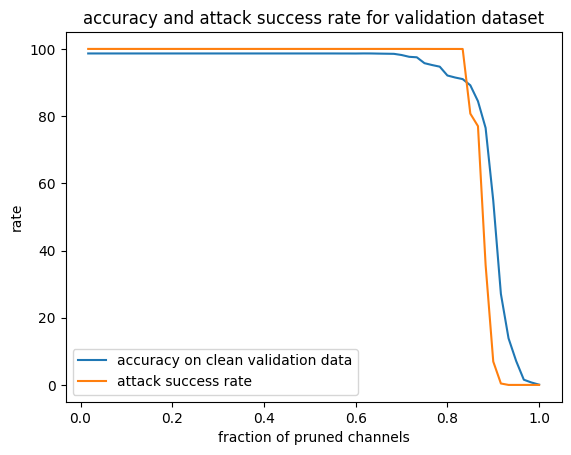

In [57]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,accuracy_clean_data)
plt.plot(x_axis,attack_success_rates)
plt.legend(['accuracy on clean validation data','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [58]:
threshold_index = np.where(np.array(accuracy_clean_data) <= (baseline_accuracy-30))[0]
print("Attack Success Rate at 30% Accuracy Drop: ", attack_success_rates[threshold_index[0]])

Attack Success Rate at 30% Accuracy Drop:  6.954187234779596


# Merging the original BadNet B with the updated BadNet B' is done after the accuracy falls below a certain threshold, X%, which in this case is set at values of 2%, 4%, or 10%.

In [59]:
class EnhancedModel(keras.Model):
    def __init__(self, PrimaryModel, SecondaryModel):
        super(EnhancedModel, self).__init__()
        self.PrimaryModel = PrimaryModel
        self.SecondaryModel = SecondaryModel

    def make_prediction(self, input_data):
        primary_pred = np.argmax(self.PrimaryModel(input_data), axis=1)
        secondary_pred = np.argmax(self.SecondaryModel(input_data), axis=1)
        final_prediction = np.zeros(input_data.shape[0])
        for index in range(input_data.shape[0]):
            if primary_pred[index] == secondary_pred[index]:
                final_prediction[index] = primary_pred[index]
            else:
                final_prediction[index] = 1283  # Assuming 1283 is a specific default or error value
        return final_prediction

## Evaluate the combined model

In [60]:
# Updated file paths for datasets and models
clean_test_dataset_path = '/content/drive/MyDrive/lab4/data/cl/test.h5'
bd_test_dataset_path = '/content/drive/MyDrive/lab4/data/bd/bd_test.h5'
model_pruned_2_percent_path = '/content/model_drop_2.h5'
model_pruned_4_percent_path = '/content/model_drop_4.h5'
model_pruned_10_percent_path = '/content/model_drop_10.h5'


In [61]:
test_model_X_2 = keras.models.load_model(model_pruned_2_percent_path)
test_model_X_4 = keras.models.load_model(model_pruned_4_percent_path)
test_model_X_10 = keras.models.load_model(model_pruned_10_percent_path)

Ignore the warnings

In [63]:
test_data_clean, test_labels_clean = load_dataset(clean_test_dataset_path)
test_data_poisoned, test_labels_poisoned = load_dataset(bd_test_dataset_path)

In [64]:
print("x_test_data shape: ",test_data_clean.shape)
print("x_test_poisoned data shape: ",test_data_poisoned.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [75]:
EnhancedModel_X_2 = EnhancedModel(model, test_model_X_2)
EnhancedModel_X_4 = EnhancedModel(model, test_model_X_4)
EnhancedModel_X_10 = EnhancedModel(model, test_model_X_10)

### Evaluating on the test dataset

In [76]:
label_pred_2_percent_clean = np.argmax(test_model_X_2.predict(test_data_clean), axis=1)
accuracy_2_percent_clean = np.mean(np.equal(label_pred_2_percent_clean, test_labels_clean)) * 100
print('Model with 2% pruning, Clean Test Data Accuracy:', accuracy_2_percent_clean)

label_pred_2_percent_poisoned = np.argmax(test_model_X_2.predict(test_data_poisoned), axis=1)
attack_success_rate_2_percent = np.mean(np.equal(label_pred_2_percent_poisoned, test_labels_poisoned)) * 100
print('Model with 2% pruning, Attack Success Rate:', attack_success_rate_2_percent)

label_pred_4_percent_clean = np.argmax(test_model_X_4.predict(test_data_clean), axis=1)
accuracy_4_percent_clean = np.mean(np.equal(label_pred_4_percent_clean, test_labels_clean)) * 100
print('Model with 4% pruning, Clean Test Data Accuracy:', accuracy_4_percent_clean)

label_pred_4_percent_poisoned = np.argmax(test_model_X_4.predict(test_data_poisoned), axis=1)
attack_success_rate_4_percent = np.mean(np.equal(label_pred_4_percent_poisoned, test_labels_poisoned)) * 100
print('Model with 4% pruning, Attack Success Rate:', attack_success_rate_4_percent)

label_pred_10_percent_clean = np.argmax(test_model_X_10.predict(test_data_clean), axis=1)
accuracy_10_percent_clean = np.mean(np.equal(label_pred_10_percent_clean, test_labels_clean)) * 100
print('Model with 10% pruning, Clean Test Data Accuracy:', accuracy_10_percent_clean)

label_pred_10_percent_poisoned = np.argmax(test_model_X_10.predict(test_data_poisoned), axis=1)
attack_success_rate_10_percent = np.mean(np.equal(label_pred_10_percent_poisoned, test_labels_poisoned)) * 100
print('Model with 10% pruning, Attack Success Rate:', attack_success_rate_10_percent)


401/401 [==============================] - 4s 10ms/step
Model with 2% pruning, Clean Test Data Accuracy: 95.90023382696803
401/401 [==============================] - 4s 10ms/step
Model with 2% pruning, Attack Success Rate: 100.0
401/401 [==============================] - 4s 11ms/step
Model with 4% pruning, Clean Test Data Accuracy: 92.29150428682775
401/401 [==============================] - 4s 10ms/step
Model with 4% pruning, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 4s 10ms/step
Model with 10% pruning, Clean Test Data Accuracy: 84.54403741231489
401/401 [==============================] - 4s 10ms/step
Model with 10% pruning, Attack Success Rate: 77.20966484801247


## Defining the fixed models

In [77]:
accuracy_test_data = [accuracy_2_percent_clean, accuracy_4_percent_clean, accuracy_10_percent_clean]
success_rates_attack = [attack_success_rate_2_percent, attack_success_rate_4_percent, attack_success_rate_10_percent]
data_summary = {
    "Test_Accuracy": accuracy_test_data,
    "Attack_Success_Rate": success_rates_attack,
    "Pruned_Model": ["Model_2%_Pruned", "Model_4%_Pruned", "Model_10%_Pruned"]
}

performance_df = pd.DataFrame(data_summary)
performance_df.set_index('Pruned_Model')


,Test_Accuracy,Attack_Success_Rate
Pruned_Model,,
Model_2%_Pruned,95.900234,100.000000
Model_4%_Pruned,92.291504,99.984412
Model_10%_Pruned,84.544037,77.209665


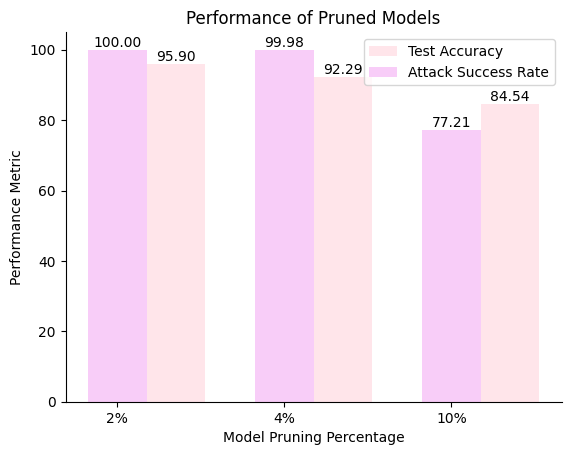

In [78]:
transparency = 0.4
width_of_bar = 0.35

plt.xlabel('Model Pruning Percentage')
plt.ylabel('Performance Metric')

plt.xticks(np.arange(len(accuracy_test_data)), ('2%', '4%', '10%'))
accuracy_bar = plt.bar(np.arange(len(accuracy_test_data)) + width_of_bar, accuracy_test_data, width_of_bar, align='center', alpha=transparency, color='pink', label='Test Accuracy')
attack_success_bar = plt.bar(np.arange(len(success_rates_attack)), success_rates_attack, width_of_bar, align='center', alpha=transparency, color='violet', label='Attack Success Rate')

# Adding data labels above bars
for bar in accuracy_bar + attack_success_bar:
    bar_height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, bar_height, f'{bar_height:.02f}', ha='center', va='bottom')

plt.legend(loc='upper right')
plt.title('Performance of Pruned Models')
sns.despine()
plt.show()

In [79]:
enhanced_clean_test_2_predictions = EnhancedModel_X_2.make_prediction(test_data_clean)
enhanced_clean_test_2_accuracy = np.mean(np.equal(enhanced_clean_test_2_predictions, test_labels_clean)) * 100
print('Enhanced Model with 2% Pruned Accuracy, Clean Test Data Classification Accuracy:', enhanced_clean_test_2_accuracy)

enhanced_attack_test_2_predictions = EnhancedModel_X_2.make_prediction(test_data_poisoned)
enhanced_model_asrate_2 = np.mean(np.equal(enhanced_attack_test_2_predictions, test_labels_poisoned)) * 100
print('Enhanced Model with 2% Pruned Accuracy, Attack Success Rate:', enhanced_model_asrate_2)

enhanced_clean_test_4_predictions = EnhancedModel_X_4.make_prediction(test_data_clean)
enhanced_clean_test_4_accuracy = np.mean(np.equal(enhanced_clean_test_4_predictions, test_labels_clean)) * 100
print('Enhanced Model with 4% Pruned Accuracy, Clean Test Data Classification Accuracy:', enhanced_clean_test_4_accuracy)

enhanced_attack_test_4_predictions = EnhancedModel_X_4.make_prediction(test_data_poisoned)
enhanced_model_asrate_4 = np.mean(np.equal(enhanced_attack_test_4_predictions, test_labels_poisoned)) * 100
print('Enhanced Model with 4% Pruned Accuracy, Attack Success Rate:', enhanced_model_asrate_4)

enhanced_clean_test_10_predictions = EnhancedModel_X_10.make_prediction(test_data_clean)
enhanced_clean_test_10_accuracy = np.mean(np.equal(enhanced_clean_test_10_predictions, test_labels_clean)) * 100
print('Enhanced Model with 10% Pruned Accuracy, Clean Test Data Classification Accuracy:', enhanced_clean_test_10_accuracy)

enhanced_attack_test_10_predictions = EnhancedModel_X_10.make_prediction(test_data_poisoned)
enhanced_model_asrate_10 = np.mean(np.equal(enhanced_attack_test_10_predictions, test_labels_poisoned)) * 100
print('Enhanced Model with 10% Pruned Accuracy, Attack Success Rate:', enhanced_model_asrate_10)

Enhanced Model with 2% Pruned Accuracy, Clean Test Data Classification Accuracy: 95.74434918160561
Enhanced Model with 2% Pruned Accuracy, Attack Success Rate: 100.0
Enhanced Model with 4% Pruned Accuracy, Clean Test Data Classification Accuracy: 92.1278254091972
Enhanced Model with 4% Pruned Accuracy, Attack Success Rate: 99.98441153546376
Enhanced Model with 10% Pruned Accuracy, Clean Test Data Classification Accuracy: 84.3335931410756
Enhanced Model with 10% Pruned Accuracy, Attack Success Rate: 77.20966484801247


In [80]:
enhanced_test_accuracy = [enhanced_clean_test_2_accuracy, enhanced_clean_test_4_accuracy, enhanced_clean_test_10_accuracy]
enhanced_attack_rate = [enhanced_model_asrate_2, enhanced_model_asrate_4, enhanced_model_asrate_10]

enhanced_data = {
    "Enhanced_Test_Accuracy": enhanced_test_accuracy,
    "Enhanced_Attack_Rate": enhanced_attack_rate,
    "Enhanced_Model": ["Enhanced_2%", "Enhanced_4%", "Enhanced_10%"]
}
enhanced_df = pd.DataFrame(enhanced_data)
enhanced_df.set_index('Enhanced_Model')


,Enhanced_Test_Accuracy,Enhanced_Attack_Rate
Enhanced_Model,,
Enhanced_2%,95.744349,100.000000
Enhanced_4%,92.127825,99.984412
Enhanced_10%,84.333593,77.209665


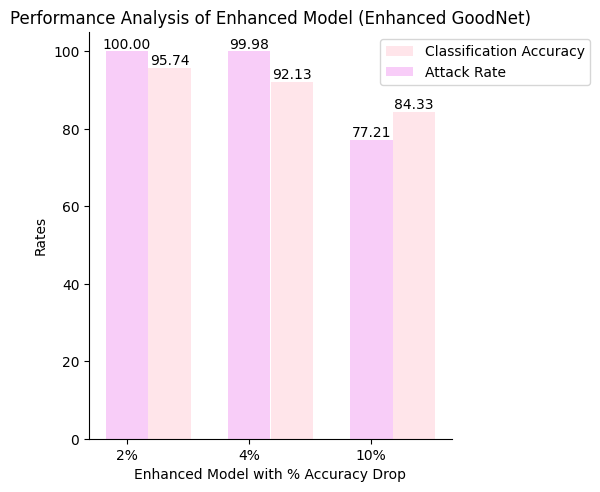

In [81]:
transparency = 0.4
bar_width = 0.35

plt.xlabel('Enhanced Model with % Accuracy Drop')
plt.ylabel('Rates')

plt.xticks(range(len(enhanced_test_accuracy)), ('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(enhanced_test_accuracy)) + bar_width, enhanced_test_accuracy, bar_width, align='center', alpha=transparency, color='pink', label='Classification Accuracy')
bar2 = plt.bar(range(len(enhanced_attack_rate)), enhanced_attack_rate, bar_width, align='center', alpha=transparency, color='violet', label='Attack Rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance Analysis of Enhanced Model (Enhanced GoodNet)')
sns.despine()
plt.show()


---